In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import glob
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
def deform(array, factor, axis):
    stretched = np.repeat(array, np.ceil(factor), axis=axis)
    indices = np.linspace(0, stretched.shape[axis] - 1, int(array.shape[axis] * factor))
    indices = np.rint(indices).astype(int)
    return np.take(stretched, indices, axis=axis)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
K.set_image_data_format('channels_last')

data_path = './'
project_name = '3D-Unet'
img_depth = 32
img_rows = 256
img_cols =256
smooth = 1.

In [4]:
def get_unet():
    inputs = Input((img_depth, img_rows, img_cols, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=2*1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [5]:
def train(video, mask):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    history = model.fit(video[:-2], mask[:-2], batch_size=1, epochs=15, verbose=1, shuffle=True, validation_split=0.20, callbacks=[model_checkpoint, csv_logger])
    
    print(history.history.keys())
    
    plt.figure(figsize=(15,15))
    plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient over time during training')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    
    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    # predicting in training function for rapid prototyping

    npy_mask_dir = 'test_mask_npy'
    if not os.path.exists(npy_mask_dir):
        os.mkdir(npy_mask_dir)

    np.save(os.path.join(npy_mask_dir, project_name + '_prediction.npy'), video[-2:])

In [6]:
# preprocessing: glue two video together, get a validation set, reshape them into the right input shapes...
input1 = np.swapaxes(np.load('input_1.npz')['arr_0'], 1, 3).shape
input2 = np.swapaxes(np.load('input_2.npz')['arr_0'], 1, 3).shape

mask1 = np.swapaxes(np.load('.npz')['arr_0'], 1, 3).shape
mask2 = np.swapaxes(np.load('.npz')['arr_0'], 1, 3).shape

input1 = deform(input1, img_depth/input1.shape[1], axis=1)
input1 = deform(input1, img_rows/input1.shape[2], axis=2)
input1 = deform(input1, img_cols/input1.shape[3], axis=3)

input2 = deform(input2, img_depth/input2.shape[1], axis=1)
input2 = deform(input2, img_rows/input2.shape[2], axis=2)
input2 = deform(input2, img_cols/input2.shape[3], axis=3)

mask1 = deform(mask1, img_depth/mask1.shape[1], axis=1)
mask1 = deform(mask1, img_rows/mask1.shape[2], axis=2)
mask1 = deform(mask1, img_cols/mask1.shape[3], axis=3)

mask2 = deform(mask2, img_depth/mask2.shape[1], axis=1)
mask2 = deform(mask2, img_rows/mask2.shape[2], axis=2)
mask2 = deform(mask2, img_cols/mask2.shape[3], axis=3)

video = np.concatenate((input1, input2), axis=0)
mask = np.concatenate((mask1, mask2), axis=0)

video = np.expand_dims(video, axis=4)
mask = np.expand_dims(mask, axis=4)

video = video.astype('float32')
mask = mask.astype('float32')

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 256, 256, 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 32, 256, 256, 27680       conv3d_1[0][0]                   
______________________________________________________________________________________________

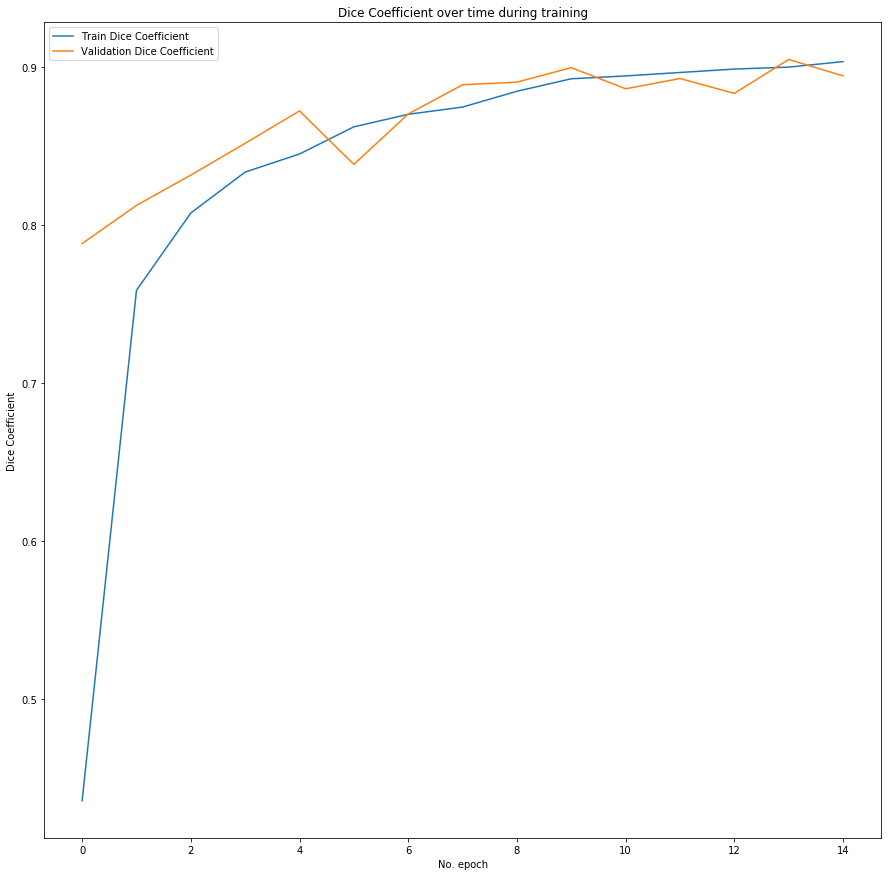

------------------------------
Training finished
------------------------------


In [8]:
train()

----------------------------------------------------------------------------------------------------------------------------

In [10]:
volume = video[-2,:,:,:,0]
truth = mask[-2,:,:,:,0]

prediction = np.load('test_mask_npy/3D-Unet_prediction.npy')[0:1][0,:,:,:,0]

print(volume.shape,truth.shape,prediction.shape)

(32, 256, 256) (32, 256, 256) (32, 256, 256)


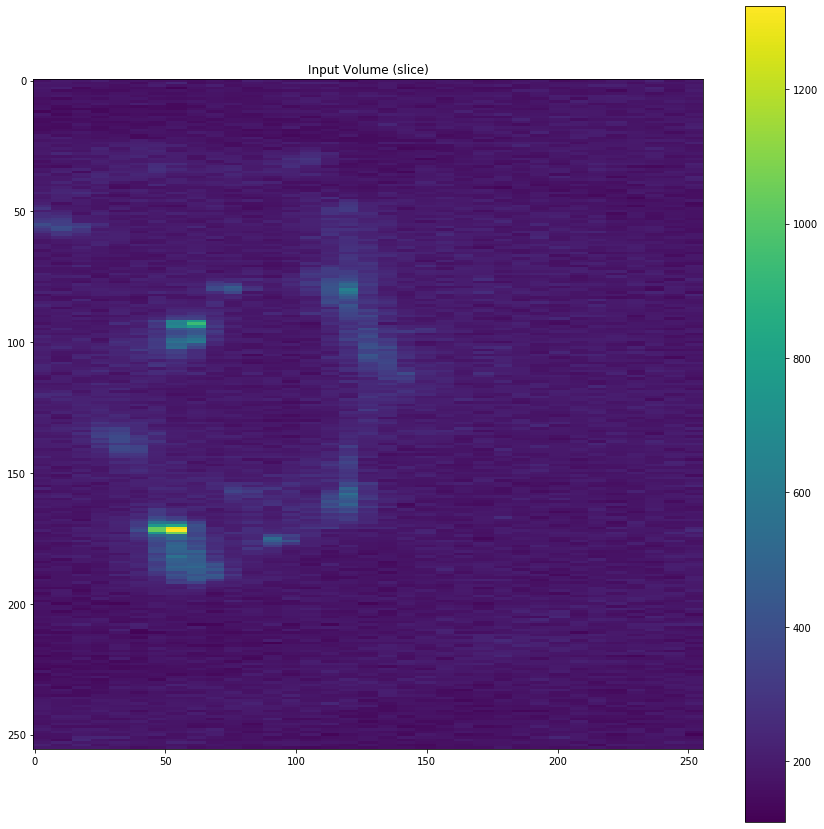

In [14]:
plt.figure(figsize=(15,15))
plt.title('Input Volume (slice)')
plt.imshow(volume[10,:,:])
plt.colorbar()

In [15]:
plt.figure(figsize=(15,15))
plt.tittle('Ground Truth')
plt.imshow(truth[15,:,:])
plt.colorbar()

AttributeError: module 'matplotlib.pyplot' has no attribute 'tittle'

<Figure size 1080x1080 with 0 Axes>

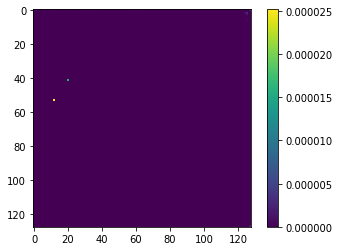

In [17]:
plt.figure(figsize=(15,15))
plt.tittle('Ground Truth')
plt.imshow(prediction[15,:,:])
plt.colorbar()

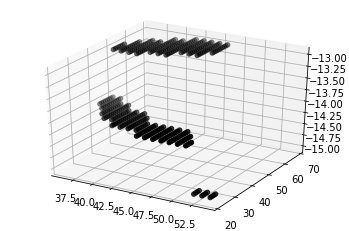

In [18]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z,x,y = b.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')

In [20]:
c = c>0.9

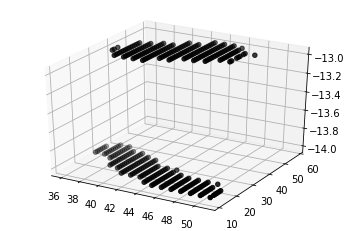

In [21]:
z,x,y = c.nonzero()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')

In [26]:
a = np.load('input_1.npz')['arr_0']
b = np.load('terminal_mask_1.npz')['arr_0']
    
d = np.load('input_2.npz')['arr_0']
e = np.load('terminal_mask_2.npz')['arr_0']

In [18]:
a = deform(a, img_depth/a.shape[1], axis=1)
a = deform(a, img_rows/a.shape[2], axis=2)
a = deform(a, img_cols/a.shape[3], axis=3)
    
b = deform(b, img_depth/b.shape[1], axis=1)
b = deform(b, img_rows/b.shape[2], axis=2)
b = deform(b, img_cols/b.shape[3], axis=3)
    
d = deform(d, img_depth/d.shape[1], axis=1)
d = deform(d, img_rows/d.shape[2], axis=2)
d = deform(d, img_cols/d.shape[3], axis=3)
    
e = deform(e, img_depth/e.shape[1], axis=1)
e = deform(e, img_rows/e.shape[2], axis=2)
e = deform(e, img_cols/e.shape[3], axis=3)

In [27]:
print(a.shape, b.shape, d.shape, e.shape)

(251, 312, 512, 35) (251, 312, 512, 35) (286, 352, 512, 35) (286, 352, 512, 35)


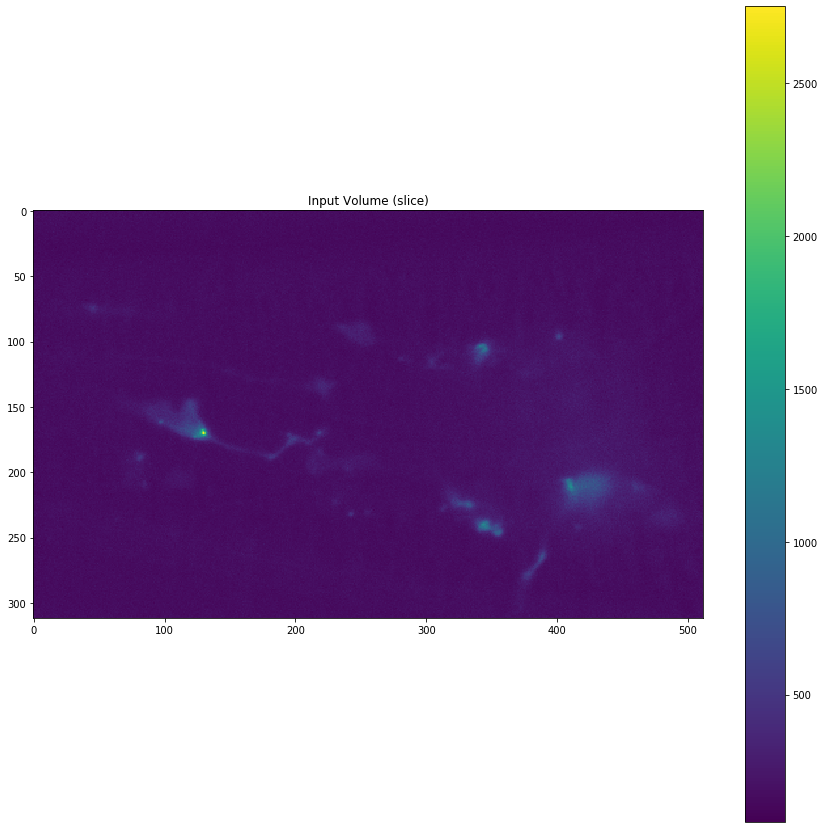

In [29]:
plt.figure(figsize=(15,15))
plt.title('Input Volume (slice)')
plt.imshow(a[10,:,:,10])
plt.colorbar()

In [7]:
a = np.array([[[1,2,3],[1,2,3]],[[1,2,3],[1,2,3]],[[1,2,3],[1,2,3]],[[1,2,3],[1,2,3]]])
print(a.shape)

(4, 2, 3)


(2, 4, 3)